# Connectivity Classifier


## Inputs

Connectivity matrices

## Outputs

Participant's label, either AVGP or NVGP.

## Requirements

To run this notebook, you need to have the rapids packages installed:

```bash
mamba create -n rapids-22.04 \
    -c rapidsai -c nvidia -y \
    rapids=22.04 python=3.9 cudatoolkit=11.5 \
    jupyterlab ipykernel nilearn xarray netcdf4 seaborn

mamba activate rapids-22.04

# [Optional] Bayesian HBO
# pip install "ray[tune]" tune-sklearn scikit-optimize
```

In [1]:
%reload_ext autoreload
%autoreload 3

import os
from pathlib import Path

import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import scipy.stats as st
import seaborn as sns
from python.acnets.pipeline import ConnectivityPipeline, ConnectivityVectorizer
from ray import tune
from ray.tune.sklearn import TuneSearchCV
from sklearn.dummy import DummyClassifier
from sklearn.feature_selection import SelectFromModel, VarianceThreshold
from sklearn.model_selection import (GridSearchCV, StratifiedShuffleSplit,
                                     cross_val_score)
from sklearn.pipeline import Pipeline
from sklearn.preprocessing import LabelEncoder, StandardScaler


try:
    from cuml import PCA, SVC, UMAP, LinearSVC
    os.environ['CUDA_VISIBLE_DEVICES'] = '0'
except ImportError:
    print('cuML not installed. Skipping GPU features.')

from sklearn.svm import LinearSVC

cuML not installed. Skipping GPU features.


In [2]:
# 0. PARAMETERS

#  WARNING: Ray Tune requires data paths to be absolute.
BIDS_DIR = Path.home() / 'workspace/acnets/data/julia2018'
CACHE_DIR = Path.home() / 'workspace/acnets/data/julia2018_resting'

In [3]:
# 1. DATA

subjects = ConnectivityPipeline().transform('all').coords['subject'].values
groups = [s[:4] for s in subjects]  # AVGP or NVGP

X = subjects.reshape(-1, 1)

y_encoder = LabelEncoder()
y = y_encoder.fit_transform(groups)

In [4]:
# 2. PIPELINE

from sklearn.decomposition import PCA

pipe  = Pipeline([
    ('connectivity', ConnectivityPipeline(bids_dir=BIDS_DIR, parcellation_cache_dir=CACHE_DIR)),
    ('vectorize', ConnectivityVectorizer()),
    ('scale', StandardScaler()),
    ('zerovar', VarianceThreshold()),
    ('select', SelectFromModel(LinearSVC(penalty='l1', dual=False, max_iter=10000))),
    # ('reduce', PCA()),
    ('clf', LinearSVC(penalty='l1', dual=False, max_iter=10000))
])

# DEBUG
# pipe.fit(X, y).score(X, y)

# DEBUG: test some good defaults
pipe.set_params(connectivity__kind='partial correlation')

scores = cross_val_score(pipe, X, y,
                         cv=StratifiedShuffleSplit(n_splits=200, test_size=8),
                         scoring='accuracy',
                         n_jobs=-1)
bootstrap_ci = st.bootstrap(scores.reshape(1,-1), np.mean)
scores.mean(), scores.std(), bootstrap_ci

(0.705625,
 0.15806322904141873,
 BootstrapResult(confidence_interval=ConfidenceInterval(low=0.683125, high=0.72625), standard_error=0.010990422302674142))

In [ ]:
%%script echo skipping bayesian optimization...

# HPO: Bayesian Optimization

param_space = {
    # 'scale': tune.choice([StandardScaler(), 'passthrough']),
    # 'select': tune.choice([SelectFromModel(LinearSVC(penalty='l2')), 'passthrough']),
    'clf__C': tune.loguniform(1e-2, 1e3),
    'connectivity__atlas': tune.choice(['dosenbach2010']),#, 'gordon2014_2mm', 'difumo_64_2mm', 'seitzman2018'],
    'connectivity__kind': tune.choice(['partial correlation', 'chatterjee', 'correlation', 'tangent']),
}

opt = TuneSearchCV(
    pipe,
    param_space,
    cv=4,
    n_trials=10,
    # early_stopping=True,
    max_iters=2,
    search_optimization='bayesian',
    verbose=1,
    scoring='accuracy',
    use_gpu=True,
    n_jobs=-1)

opt.fit(X, y)

print('best estimator:', opt.best_estimator_)


skipping bayesian optimization...


In [ ]:
# HPO: Grid Search

param_grid = {
    # 'connectivity__atlas': ['gordon2014_2mm', 'dosenbach2010', 'difumo_64_2mm'],
    'connectivity__atlas': ['dosenbach2010'],
    'connectivity__kind': ['partial correlation', 'chatterjee', 'tangent'],
}

grid = GridSearchCV(
    pipe,
    param_grid,
    cv=StratifiedShuffleSplit(n_splits=100, test_size=8),
    verbose=1,
    scoring='accuracy')

grid.fit(X, y)

print('best estimator:', grid.best_estimator_)


Fitting 100 folds for each of 3 candidates, totalling 300 fits
best estimator: Pipeline(steps=[('connectivity',
                 ConnectivityPipeline(bids_dir=PosixPath('/Users/morteza/workspace/acnets/data/julia2018'), kind='partial correlation', parcellation_cache_dir=PosixPath('/Users/morteza/workspace/acnets/data/julia2018_resting'))),
                ('vectorize', ConnectivityVectorizer()),
                ('scale', StandardScaler()), ('zerovar', VarianceThreshold()),
                ('select',
                 SelectFromModel(estimator=LinearSVC(dual=False, max_iter=10000,
                                                     penalty='l1'))),
                ('clf', LinearSVC(dual=False, max_iter=10000, penalty='l1'))])


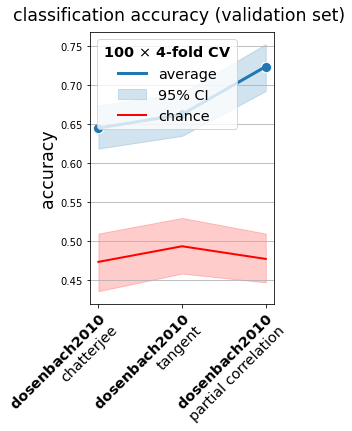

In [ ]:
def _create_label(params):
    return f'$\\bf{{{params[0]}}}$\n{params[1]}'.replace('_', '\\_')


def plot_scores(grid, X=None, y=None, plot_chance=True):

    # prep data
    scores = pd.DataFrame(grid.cv_results_)
    scores['label'] = scores['params'].apply(lambda p: _create_label(list(p.values())))
    split_score_cols = [c for c in scores.columns if 'split' in c]
    scores['cv_test_score'] = scores[split_score_cols].apply(lambda x: list(x), axis=1)
    scores = scores.explode('cv_test_score').reset_index(drop=True)
    scores = scores.sort_values('rank_test_score', ascending=False)

    _, ax = plt.subplots(figsize=(len(grid.cv_results_['params']) * 1.1, 5))

    # score curve + CI
    sns.lineplot(data=scores, x='label', y='cv_test_score', lw=3, sort=False, ax=ax)

    # blue dots
    sns.scatterplot(data=scores, x='label', y='mean_test_score', marker='o', s=100, ax=ax, label='_nolegend_')

    if plot_chance:
        # simulate chance
        chance_scores = {}
        for model_name in scores['label'].unique():
            chance_model = DummyClassifier(strategy='stratified').fit(X, y)
            _chance_scores = cross_val_score(chance_model, X, y, cv=grid.cv, scoring=grid.scoring)
            chance_scores[model_name] = _chance_scores

        chance_scores = pd.DataFrame(chance_scores)
        chance_scores = chance_scores.melt(value_name=grid.scoring, var_name='label')

        # plot chance
        sns.lineplot(data=chance_scores, x='label', y=grid.scoring, lw=2, sort=False, ax=ax, color='red')

    # legend
    ax.legend(['average', '95% CI', 'chance'],
                title_fontproperties={'weight': 'bold', 'size': 'x-large'},
                prop={'size': 'x-large'}, loc='upper left',
                title=f'{grid.cv.n_splits} $\\times$ {32 // grid.cv.test_size}-fold CV')

    # tweaks
    ax.set_xlabel('')
    ax.set_ylabel(grid.scoring, fontsize='xx-large')
    plt.xticks(rotation=45, ha='right', fontsize='x-large', rotation_mode='anchor')
    plt.suptitle(f'classification {grid.scoring} (validation set)', fontsize='xx-large', y=.95)
    plt.grid(axis='y')



plot_scores(grid, X, y)
plt.show()

[Parallel(n_jobs=-1)]: Using backend LokyBackend with 12 concurrent workers.
[Parallel(n_jobs=-1)]: Done  26 tasks      | elapsed:    6.6s
[Parallel(n_jobs=-1)]: Done 100 out of 100 | elapsed:   17.9s finished


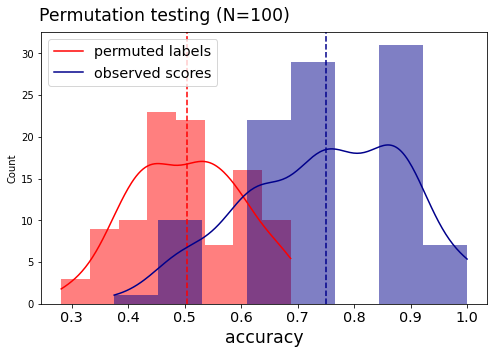

In [ ]:
from sklearn.model_selection import permutation_test_score

_, perm_scores, pvalue = permutation_test_score(grid.best_estimator_, X, y,
                                                scoring='accuracy',
                                                n_permutations=100,
                                                cv=4,
                                                n_jobs=-1, verbose=1)

cv_scores = cross_val_score(grid.best_estimator_, X, y,
                            cv=StratifiedShuffleSplit(n_splits=100, test_size=8),
                            scoring='accuracy', n_jobs=-1)


# Now plot permuted scores along with the cross-validated scores

_, ax = plt.subplots(figsize=(8,5))

# permutation scores
sns.histplot(perm_scores, kde=True, ax=ax, color='red', lw=0)
ax.axvline(perm_scores.mean(), color='red', ls='--', label='_nolegend_')

# observation scores
sns.histplot(cv_scores, kde=True, ax=ax, color='darkblue', lw=0)
ax.axvline(cv_scores.mean(), color='darkblue', ls='--', label='_nolegend_')

# tweaks
plt.xlabel('accuracy', fontsize='xx-large')
plt.xticks(fontsize='x-large')

plt.suptitle(f'Permutation testing (N={len(perm_scores)})', x = .34, y=.95, fontsize='xx-large')
plt.legend(['permuted labels', 'observed scores'], loc='upper left', fontsize='x-large')

plt.show()

In [ ]:
from sklearn.inspection import permutation_importance
from tqdm.auto import tqdm

cv = StratifiedShuffleSplit(n_splits=100, test_size=8)

model: Pipeline = grid.best_estimator_  # type: ignore

model.set_params(connectivity__kind='tangent')

X_conn = model[:2].transform(X)
feature_names = model[:2].get_feature_names_out()

importances = []

for train, test in tqdm(cv.split(X,y), total=cv.get_n_splits(X,y)):
    model.fit(X[train], y[train])

    results = permutation_importance(model[2:], X_conn[test], y[test],
                                     scoring=grid.scoring,
                                     n_jobs=1)
    importances.append(results.importances.T)


importances = pd.DataFrame(np.vstack(importances), columns=feature_names)


  0%|          | 0/100 [00:00<?, ?it/s]

In [ ]:
importances

In [ ]:
# PLOT FEATURE IMPORTANCE

# sort by mean importance
sorted_columns = importances.mean(axis=0).sort_values(ascending=False).index
perm_imp_scores = importances[sorted_columns]

_, ax = plt.subplots(1,1,figsize=(5,7))
sns.barplot(data=perm_imp_scores,
            orient='horizontal',
            capsize=.3,
            errwidth=2,
            ax=ax)

plt.xticks(fontsize='x-large')
plt.yticks(fontsize='x-large')
plt.show()

## Appendix

In [47]:
# Learning Curve Analysis

from sklearn.model_selection import learning_curve
import pandas as pd

train_sizes, train_scores, test_scores = learning_curve(grid.best_estimator_, X, y,
                                                        cv=StratifiedShuffleSplit(n_splits=10, test_size=8),
                                                        scoring='accuracy',
                                                        n_jobs=-1,
                                                        shuffle=True,
                                                        train_sizes=np.array([16, 18, 20, 22, 24]))


learning_curve_results = pd.DataFrame({
    'train_size': train_sizes,
    'mean_train_score': train_scores.mean(axis=1),
    'mean_test_score': test_scores.mean(axis=1)
})

learning_curve_results

,train_size,mean_train_score,mean_test_score
0,16,0.968750,0.6500
1,18,0.972222,0.6875
2,20,0.965000,0.6500
3,22,0.972727,0.6875
4,24,0.950000,0.7500
